In [1]:
import sys
import numpy as np
import scipy.special as sps
from tqdm import tqdm_notebook
import pickle
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init as z
import update_params as zz

sns.set(rc={'figure.figsize':(11, 4)})

## definitions
z.fnc_type = 0 # 0 =  benchmark, 1 = treat senior spec.
z.R0_type = 1  # 0 = normal, 1 = low, 2 = high
zz.set_params()

out_filename_root,fig_rootname,stat_rootname=z.setup_paths(z.fnc_type,z.R0_type)

filename_pct = "SIR_pct.pickle"
filename_raw = "SIR_raw.pickle"
out_filename = "SIR.pickle"

# setup paths
out_filename = out_filename_root+"/"+out_filename
print(out_filename)

lastday = 100
reported_cases = [1,3,5,7,7,10,21,32,44]
num_rep = len(reported_cases)

pct_SIR = []
raw_SIR = []
alpha_vec = []
pct_SIR_S = []
pct_SIR_I = []
pct_SIR_R = []
abs_SIR_S = []
abs_SIR_I = []
abs_SIR_R = []
raw_SIR_S = []
raw_SIR_I = []
raw_SIR_R = []
pct_SIR_IR = []
abs_SIR_IR = []
pop_size = z.pop_N.sum()

def load_organise_data():
    with open(out_filename,'rb') as fid:
        pct_SIR,raw_SIR,alpha_vec = pickle.load(fid)
    fid.close()
    num = len(alpha_vec)
    leg_full = []
    leg_full_IR = []
    for idx in range(num):
        pct_SIR_I.append(pct_SIR[idx].inf) 
        pct_SIR_S.append(pct_SIR[idx].sus) 
        pct_SIR_R.append(pct_SIR[idx].rec) 
        pct_SIR_IR.append(pct_SIR[idx].inf)
        pct_SIR_IR.append(pct_SIR[idx].rec)
        abs_SIR_I.append(pop_size*pct_SIR[idx].inf)
        abs_SIR_S.append(pop_size*pct_SIR[idx].sus) 
        abs_SIR_R.append(pop_size*pct_SIR[idx].rec)    
        abs_SIR_IR.append(pop_size*pct_SIR[idx].inf)
        abs_SIR_IR.append(pop_size*pct_SIR[idx].rec) 
        raw_SIR_S.append(raw_SIR[idx][:,0,:])
        raw_SIR_I.append(raw_SIR[idx][:,1,:])
        raw_SIR_R.append(raw_SIR[idx][:,2,:])
        v = str(np.round(100*alpha_vec[idx]))
        leg_full.append(v+"%")
        leg_full_IR.append("I+"+v+"%")
        leg_full_IR.append("R+"+v+"%")
    return alpha_vec,num,leg_full,leg_full_IR

## load and organise data
alpha_vec,num,leg_full,leg_full_IR=load_organise_data()
alpha_idx_vec = [0,num-8,num-6]

##  definitions of plotting and saving functions
def set_fig_style():
    plt.rc('savefig',dpi=300)
    #plt.rc('title',weight='bold')
    plt.rc('axes',facecolor='white')
    plt.rc('grid',linestyle='-',color='gray',alpha=.15)
    
def plot_peaks(data,idx_arr,y_max,scale):
    leg_vec = []
    for idx in (idx_arr):
        plt.plot(x,scale*data[idx],alpha=.9)
        plt.xlim((0,z.simul_len))
        plt.ylim((0,y_max))
        leg_vec.append(str(100*int(alpha_vec[idx]*100)/100+1)+"%")
    plt.grid(True)    
    return leg_vec,plt
        
def cmp_cases(data,idx_arr,col_arr):
    leg_vec = []
    k=0
    for idx in (idx_arr):
        dat = pd.DataFrame({'Vsetky pripady':np.concatenate([np.array(reported_cases),abs_SIR_I[idx]]),
                   'Zachytene pripady':np.concatenate([[0,0,0,0,0],np.array(reported_cases),abs_SIR_I[idx][:-5]])})
        plt.plot(x,dat['Zachytene pripady'][0:z.simul_len],c=col_arr[k],alpha=1,linewidth=1)
        plt.plot(x,dat['Vsetky pripady'][0:z.simul_len],c=col_arr[k],alpha=1,linewidth=1,linestyle='-.')
        k+=1
        leg_vec.append("Rep, alpha = "+str(100*int(alpha_vec[idx]*100)/100+1)+"%")
        leg_vec.append("All, alpha = "+str(100*int(alpha_vec[idx]*100)/100+1)+"%")
    return leg_vec,plt
    
    
def plot_infect_growth(data,idx_arr,y_min,y_max,rel):
    leg_vec = []
    for idx in idx_arr:
        # y = data_arr[idx][:,1,:].sum(0)
        # y = sumlist(data_arr[idx])[1,:].sum(0)
        y = data[idx].to_numpy()
        if rel:
            plt.plot(x,100*(y[1:lastday]/y[0:lastday-1]-1),alpha=0.9,linewidth=2)
        else:
            plt.plot(x,(y[1:lastday]-y[0:lastday-1]),alpha=0.9,linewidth=2)
        plt.xlim((0,lastday))
        plt.ylim((y_min,y_max))
        leg_vec.append(str(100*int(alpha_vec[idx]*100)/100+1)+"%")
    plt.grid(True)
    return leg_vec,plt
        
def export_res():
    pd.DataFrame(np.array(pct_SIR_S).transpose(),columns=leg_full).to_csv(stat_rootname+"/pct_S.csv")
    pd.DataFrame(np.array(pct_SIR_I).transpose(),columns=leg_full).to_csv(stat_rootname+"/pct_I.csv")
    pd.DataFrame(np.array(pct_SIR_R).transpose(),columns=leg_full).to_csv(stat_rootname+"/pct_R.csv")
    pd.DataFrame(np.array(abs_SIR_S).transpose(),columns=leg_full).to_csv(stat_rootname+"/abs_S.csv")
    pd.DataFrame(np.array(abs_SIR_I).transpose(),columns=leg_full).to_csv(stat_rootname+"/abs_I.csv")
    pd.DataFrame(np.array(abs_SIR_R).transpose(),columns=leg_full).to_csv(stat_rootname+"/abs_R.csv")
    pd.DataFrame(np.array(pct_SIR_IR).transpose(),columns=leg_full_IR).to_excel(stat_rootname+"/pct_IR.xlsx",engine='xlsxwriter')    
    pd.DataFrame(np.array(abs_SIR_IR).transpose(),columns=leg_full_IR).to_excel(stat_rootname+"/abs_IR.xlsx",engine='xlsxwriter')    
    #pd.DataFrame(np.concatenate([np.array(abs_SIR_I),np.array(abs_SIR_R)]).transpose(),
    #            columns=leg_full_IR).to_excel(stat_rootname+"/abs_IR.xlsx",engine='xlsxwriter')
    
## Plotting   

# 1.A compare peaks (as a function of pop.mobility alpha), relative numbers, HIGH alpha
x = np.arange(1,z.simul_len+1)
idx_arr = np.arange(alpha_idx_vec[2],num)
set_fig_style()
plt.subplot(121)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,10,100)
# plt.legend(leg)
plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")

#set_fig_style()
plt.subplot(122)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,pop_size*0.1,pop_size)
plt.legend(leg)
#plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.savefig(fig_rootname+"/peaks_alpha_high.png",dpi=300)
plt.close

./out/R0low/SIR.pickle


<function matplotlib.pyplot.close(fig=None)>

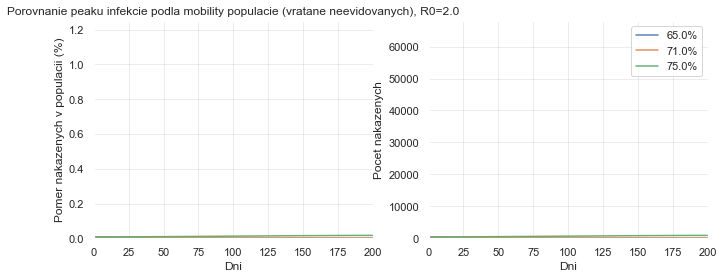

In [4]:
# 1.B compare peaks (as a function of pop.mobility alpha), absolute numbers, MEDIUM alpha
idx_arr = np.arange(alpha_idx_vec[1],alpha_idx_vec[2]+1)
set_fig_style()
plt.subplot(121)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,1.25,100)
#plt.legend(leg)
plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")

plt.subplot(122)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,pop_size*0.0125,pop_size)
plt.legend(leg)
# plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.savefig(fig_rootname+"/peaks_alpha_med.png",dpi=300)
plt.close

In [ ]:
# 1.C compare peaks (as a function of pop.mobility alpha), for small alpha, relative numbers, LOW alpha
x = np.arange(1,z.simul_len+1)
idx_arr = np.arange(alpha_idx_vec[0],alpha_idx_vec[1])
set_fig_style()
plt.subplot(121)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,0.008,100)
#plt.legend(leg)
plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")

plt.subplot(122)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,pop_size*0.00008,pop_size)
plt.legend(leg)
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.savefig(fig_rootname+"/peaks_alpha_low.png",dpi=300)
plt.close

In [ ]:
## 2.A compare growth of infectious persons (absolute numbers, daily basis),HIGH alpha
idx_arr = np.arange(alpha_idx_vec[2],num)
x = np.arange(1,lastday)
set_fig_style()
plt.subplot(121)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,-3000,15000,rel=False)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Zmena stavu (pocet ludi)")
plt.xlabel("Dni")
# plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.subplot(122)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,-5,20,rel=True)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Relativne zmeny (%)")
plt.xlabel("Dni")
plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.savefig(fig_rootname+"/infect_growth_alpha_high.png",dpi=300)
plt.close

In [ ]:
## 2.B compare growth of infectious persons (absolute numbers, daily basis),MEDIUM alpha
idx_arr = np.arange(alpha_idx_vec[1],alpha_idx_vec[2]+1)
x = np.arange(1,lastday)
set_fig_style()
plt.subplot(121)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,0,2000,rel=False)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Zmena stavu (pocet ludi)")
plt.xlabel("Dni")
# plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.subplot(122)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,0,10,rel=True)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Relativne zmeny (%)")
plt.xlabel("Dni")
plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.savefig(fig_rootname+"/infect_growth_alpha_med.png",dpi=300)
plt.close

In [ ]:
## 3 compare reported vs. all infected, HIGH alpha
x = np.arange(1,z.simul_len+1)
idx_arr = np.arange(alpha_idx_vec[2]+1,num,2)
col_arr = ['red','green','blue','orange']

set_fig_style()
plt.subplot(121)
leg,plt=cmp_cases(abs_SIR_I,idx_arr,col_arr)
plt.xlim(0,50)
plt.ylim(0,25000)
plt.xlabel('Dni')
plt.ylabel('Pocet')
plt.legend(leg)
plt.title('Vsetci vs.registrovani infikovani')

idx_arr = np.arange(alpha_idx_vec[2]-3,alpha_idx_vec[2],1)
set_fig_style()
plt.subplot(122)
leg,plt=cmp_cases(abs_SIR_I,idx_arr,col_arr)
plt.xlim(0,50)
plt.ylim(0,1500)
plt.xlabel('Dni')
plt.ylabel('Pocet')
plt.legend(leg)

plt.savefig(fig_rootname+"/known_unknown.png",dpi=300)
plt.close

In [ ]:
## saving stuff
export_res()